In [3]:
from os.path import dirname, join, abspath
import transforms3d.quaternions as quaternions
import transforms3d.euler as euler
import pandas as pd 
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import pickle
import pywt
from numpy import random

from pathlib import Path
import os,sys
import os.path


## keypoint detection

In [1]:
from keypoint_detection import Keypoint_detector
kp_detector = Keypoint_detector(weights_path="weights/pose_cfg_test.yamlsnapshot-1030000" , config="../keypoint_optimization/pose_cfg_test.yaml")

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
Running the weights: weights/pose_cfg_test.yamlsnapshot-1030000


/home/jingpei/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-10 15:25:44.503303: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 15:25:44.567717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 15:25:44.572684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had ne

In [4]:
img = cv2.imread("pose_0/1601087741221816848.png")
imgScale = 0.25
newX,newY = img.shape[1]*imgScale, img.shape[0]*imgScale
resized_img = cv2.resize(img,(int(newX),int(newY)))

results = kp_detector.predict_single_image(resized_img)
points_predicted = results[:,:2] * 4
points_predicted = points_predicted.astype(int)
scores = results[:,2]
img = kp_detector.overwrite_image(img, points_predicted, scores)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

2021-12-10 15:25:51.303653: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


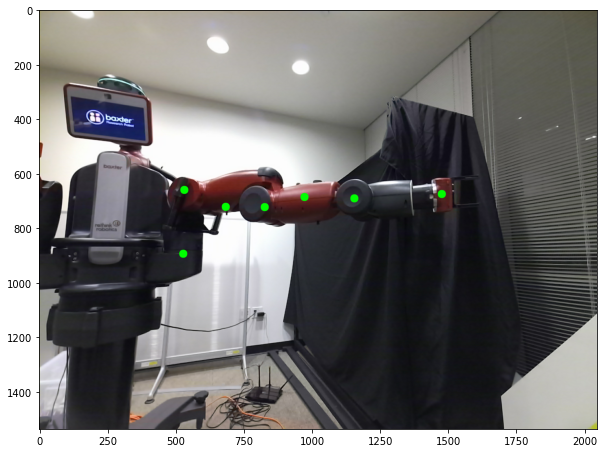

In [5]:
%matplotlib inline  
plt.figure(figsize = (10,10))
plt.imshow(img)

## pose estimation

In [6]:
## camera matrix
D = np.array([0.567073404788971, -2.7885663509368896, 0.00028499795007519424, -0.00044706949847750366, 1.6859828233718872, 0.44618695974349976, -2.613954544067383, 1.6093868017196655])
K = np.array([960.41357421875, 0.0, 1021.7171020507812, 0.0, 960.22314453125, 776.2381591796875, 0.0, 0.0, 1.0])
P = np.array( [960.41357421875, 0.0, 1021.7171020507812, 0.0, 960.22314453125, 776.2381591796875, 0.0, 0.0, 1.0]).reshape(3,3)

In [7]:
# baxter FK
from baxter_fk import Baxter_FK
baxter = Baxter_FK("keypoint_config.json")

# load joint angle data
gt_data = pickle.load( open( "ground_truth_data", "rb" ))
joints = gt_data['pose_0']['joints']


In [8]:
feature_ids = [0,4,7,9,13,15,18]

# keypoint 3d position
points_3d = np.zeros((1,3))
for i in feature_ids:
    points_3d = np.vstack((points_3d,baxter.get_3d_position_to_bl(i,joints).reshape(-1)[:3]))
points_3d = points_3d[1:,:].astype(np.float32)

# keypoint 2d position
points_2d = points_predicted

# using EPnP to find the cam-to-base transform
retval,rvec,tvec = cv2.solvePnP(points_3d,points_2d.astype(float),P,distCoeffs = D, flags = 1)
R,_ = cv2.Rodrigues(rvec)
quat_tmp = quaternions.mat2quat(R)
quat = [quat_tmp[1],quat_tmp[2],quat_tmp[3],quat_tmp[0]]

pose = np.hstack((R,tvec))
pred_pose = np.vstack((pose,[0,0,0,1]))
print(pred_pose)

[[ 0.81936258  0.57156693  0.04422909 -0.5866573 ]
 [-0.0211456   0.1072316  -0.99400918  0.15194448]
 [-0.57288553  0.81351867  0.09994769  1.18097142]
 [ 0.          0.          0.          1.        ]]


## visualize the prediction

In [9]:
def dehomogenize_3d(vec):
    vec = vec.reshape((-1,1))
    vec = vec/vec[3]
    return vec[:3]
def dehomogenize_2d(vec):
    vec = vec.reshape((-1,1))
    vec = vec/vec[2]
    return vec[:2]
def T_from_DH(alp,a,d,the):
    T = np.array([[np.cos(the), -np.sin(the), 0, a],
                  [np.sin(the)*np.cos(alp), np.cos(the)*np.cos(alp), -np.sin(alp), -d*np.sin(alp)],
                  [np.sin(the)*np.sin(alp), np.cos(the)*np.sin(alp), np.cos(alp), d*np.cos(alp)],
                  [0,0,0,1]])
    return T


def get_camera_matrix():
    P = np.array(K)
    P = P.reshape((3,3))
    return P
def get_coor_by_P(v_pos):
    v_pos = v_pos.reshape(3,1)
    v_pos = v_pos.astype(float)
    mtx = get_camera_matrix()
    dist = np.array(D)
    
    p_2d,_ = cv2.projectPoints(v_pos,rvec = (0,0,0), tvec = (0,0,0),cameraMatrix = mtx, distCoeffs = dist)
    p_2d = p_2d.astype(int)

    return p_2d.ravel()

def project_to_img(vec,pose):
    v = np.ones(4)
    v[0] = vec[0]
    v[1] = vec[1]
    v[2] = vec[2]
    p = pose @ v
    p = dehomogenize_3d(p)
    P = get_camera_matrix()
    coord = dehomogenize_2d(P @ p)
    #p = p.reshape(3,1)
    #coord = get_coor_by_P(p)
    return coord.astype(int)
def draw_axis(img, pose):
    ori = project_to_img([0,0,0],pose)
    x = project_to_img([0.2,0,0],pose)
    y = project_to_img([0.0,0.2,0],pose)
    z = project_to_img([0.0,0,0.2],pose)
    img = cv2.line(img,tuple(ori.ravel()), tuple(x.ravel()), (255,0,0), 18)
    img = cv2.line(img,tuple(ori.ravel()), tuple(y.ravel()), (0,255,0), 18)
    img = cv2.line(img,tuple(ori.ravel()), tuple(z.ravel()), (0,0,255), 18)
    return img

def draw_skeleton(img,pose,theta):
    def to_image(p):
        p = dehomogenize_3d(p)
        #p = p.reshape(3,1)
        #coord = get_coor_by_P(p)
        coord = dehomogenize_2d(P @ p)
        coord = coord.astype(int)
        return coord
    bl_T_0 = np.array([[1,0,0,0],
                       [0,1,0,0],
                       [0,0,1,0.27035],
                       [0,0,0,1]])
    T_7_ee = np.array([[1,0,0,0],
                       [0,1,0,0],
                       [0,0,1,0.3683],
                       [0,0,0,1]])
    T_0_1 = T_from_DH(0,0,0,theta[0])
    T_1_2 = T_from_DH(-np.pi/2,0.069,0,theta[1]+np.pi/2)
    T_2_3 = T_from_DH(np.pi/2,0,0.36435,theta[2])
    T_3_4 = T_from_DH(-np.pi/2,0.069,0,theta[3])
    T_4_5 = T_from_DH(np.pi/2,0,0.37429,theta[4])
    T_5_6 = T_from_DH(-np.pi/2,0.010,0,theta[5])
    T_6_7 = T_from_DH(np.pi/2,0,0,theta[6])
    p = pose @ T_0_1 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_1 = to_image(p)
    p = pose @ bl_T_0  @ T_0_1 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_2 = to_image(p)
    img = cv2.line(img,tuple(coord_1.ravel()), tuple(coord_2.ravel()), (250,14,250), 15)
    img = cv2.circle(img,tuple(coord_2.ravel()), 20, (250,14,250), -1)
    
    p = pose @ bl_T_0  @ T_0_1 @ T_1_2 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_3 = to_image(p)
    img = cv2.line(img,tuple(coord_2.ravel()), tuple(coord_3.ravel()), (140,14,250), 15)
    img = cv2.circle(img,tuple(coord_3.ravel()), 20, (140,14,250), -1)
    
    p = pose @ bl_T_0  @ T_0_1 @ T_1_2 @ T_2_3 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_4 = to_image(p)
    img = cv2.line(img,tuple(coord_3.ravel()), tuple(coord_4.ravel()),  (11,14,250), 15)
    img = cv2.circle(img,tuple(coord_4.ravel()), 20, (11,14,250), -1)
    
    p = pose @ bl_T_0  @ T_0_1 @ T_1_2 @ T_2_3 @ T_3_4 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_5 = to_image(p)
    img = cv2.line(img,tuple(coord_4.ravel()), tuple(coord_5.ravel()), (11,250,209), 15)
    img = cv2.circle(img,tuple(coord_5.ravel()), 20, (11,250,209), -1)
    
    p = pose @ bl_T_0  @ T_0_1 @ T_1_2 @ T_2_3 @ T_3_4 @ T_4_5 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_6 = to_image(p)
    img = cv2.line(img,tuple(coord_5.ravel()), tuple(coord_6.ravel()), (11,250,98), 15) 
    img = cv2.circle(img,tuple(coord_6.ravel()), 20, (11,250,98), -1)
    
    p = pose @ bl_T_0  @ T_0_1 @ T_1_2 @ T_2_3 @ T_3_4 @ T_4_5 @ T_5_6 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_7 = to_image(p)
    img = cv2.line(img,tuple(coord_6.ravel()), tuple(coord_7.ravel()), (179,249,11), 15)   
    img = cv2.circle(img,tuple(coord_7.ravel()), 20, (179,249,11), -1)
    
    p = pose @ bl_T_0  @ T_0_1 @ T_1_2 @ T_2_3 @ T_3_4 @ T_4_5 @ T_5_6 @ T_6_7 @ np.array([0,0,0,1]).reshape(-1,1)
    coord_8 = to_image(p)
    img = cv2.line(img,tuple(coord_7.ravel()), tuple(coord_8.ravel()),  (249,209,11), 15)  
    img = cv2.circle(img,tuple(coord_8.ravel()), 20, (249,209,11), -1)
    
    p = pose @ bl_T_0  @ T_0_1 @ T_1_2 @ T_2_3 @ T_3_4 @ T_4_5 @ T_5_6 @ T_6_7 @ T_7_ee @ np.array([0,0,0,1]).reshape(-1,1)
    coord_9 = to_image(p)
    img = cv2.line(img,tuple(coord_8.ravel()), tuple(coord_9.ravel()),  (249,106,11), 15)  
    img = cv2.circle(img,tuple(coord_9.ravel()), 20, (249,106,11), -1)
    
    return img

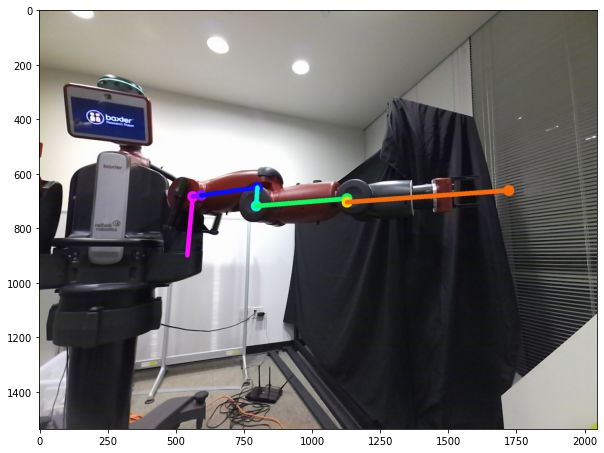

In [10]:
img = cv2.imread("pose_0/1601087741221816848.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = draw_skeleton(img,pred_pose,joints)
plt.figure(figsize = (10,10))
plt.imshow(img)

# Evaluate 2d and 3d EE pose error

In [11]:
def get_joint_angles(pose_idx):
    joints = np.array(ground_truth["pose_" + str(pose_idx)]['joints'])
    return joints



def get_ee_position(image_file, feature_ids, kp_detector, pose_idx, imgScale = 0.25):
    img = cv2.imread(image_file)
    newX,newY = img.shape[1]*imgScale, img.shape[0]*imgScale
    resized_img = cv2.resize(img,(int(newX),int(newY)))
    
    results = kp_detector.predict_single_image(resized_img)
    points_predicted = results[:,:2] * (1/imgScale)
    points_predicted = points_predicted.astype(int)
    scores = results[:,2]
    
    joints = get_joint_angles(pose_idx)
    
    
    points_3d = np.zeros((1,3))
    for i in feature_ids:
        points_3d = np.vstack((points_3d,baxter.get_3d_position_to_bl(i,joints)[:3].reshape(-1)))
    points_3d = points_3d[1:,:].astype(np.float32)

    points_2d = points_predicted#[:len(feature_ids)]

    P = get_camera_matrix()
    dist = np.array(D)

    retval,rvec,tvec = cv2.solvePnP(points_3d,points_2d.astype(float),P,distCoeffs = dist, flags = 1)
    R,_ = cv2.Rodrigues(rvec)
    quat_tmp = quaternions.mat2quat(R)
    quat = [quat_tmp[1],quat_tmp[2],quat_tmp[3],quat_tmp[0]]

    pose = np.hstack((R,tvec))
    pred_pose = np.vstack((pose,[0,0,0,1]))
    
    ee_3d = pred_pose @ baxter.get_bl_T_Jn(8,joints) @ np.array([0,0,0,1]).reshape((-1,1))
    ee_3d = dehomogenize_3d(ee_3d).reshape(-1)
    
    ee_2d = get_coor_by_P(ee_3d)
    #P = get_camera_matrix()
    #ee_2d = dehomogenize_2d(P @ ee_3d.reshape(3,1))
    ee_2d = ee_2d.reshape(-1)
    
    return ee_3d, ee_2d
    


In [12]:
import pickle
# path for baxter dataset
filename = "/home/jingpei/Desktop/keypoint_optimization-main/pose_estimation/experiments/ground_truth_data"
infile = open(filename,'rb')
ground_truth = pickle.load(infile)
infile.close()

In [13]:
import glob
opt_2d_list = []
opt_3d_list = []
for pose_idx in range(20):
    path = "/home/jingpei/Desktop/keypoint_optimization-main/pose_estimation/experiments/pose_" + str(pose_idx) + "/raw/*.png"
    file_list = glob.glob(path)
    gt_2d = np.array(ground_truth["pose_" + str(pose_idx)]['ee_2d'])
    gt_3d = np.array(ground_truth["pose_" + str(pose_idx)]['ee_3d'])

    for image_file in file_list:
        ee_3d, ee_2d = get_ee_position(image_file ,feature_ids, kp_detector, pose_idx)
        err_2d = np.linalg.norm(gt_2d - ee_2d)
        err_3d = np.linalg.norm(gt_3d - ee_3d)
        opt_2d_list.append(err_2d)
        opt_3d_list.append(err_3d)

In [14]:
np.mean(opt_2d_list)

49.51364686755569

In [15]:
np.mean(opt_3d_list)

0.14104992329002503